## Vehicle Classifier (Car v/s Not Car)


In [1]:
import cv2
import glob
import time
import pickle
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label

#from moviepy.editor import VideoFileClip
from IPython.display import HTML

from classifier import ImageClassifier
from classifier import ImageFeatureExtractor

%matplotlib inline

In [30]:
class ImageHeatmap(object):
    '''
    Heat map of image region
    '''
    
    def __init__(self, threshold = 1):
        '''
        Initialise heatmap for image
        '''
        self.threshold = threshold
        self.frame_heatmaps = []
        self.frames = 0
        
    def addHeatmapRegions(self, heatmap, regions, across_frames = True, verbose = False):
        '''
        Add heat for identified regions
        param: heatmap - heat matrix
        param: regions - coordinates of the rectagle regions in the form ((x1, y1) , (x2, y2))
        param: across_frames - average is taken across last 10 frames if set to True
        return: heatmap matrix with added heat for regions
        '''
        
        for region in regions:
            x1 = region[0][0]
            y1 = region[0][1]
            x2 = region[1][0]
            y2 = region[1][1]
            
            # add heat for this rectangle
            heatmap[y1:y2, x1:x2] += 1
        
        # apply average frames
        if across_frames == True:
            if self.frames >= 5:
                self.frame_heatmaps.pop(0)
            else:
                self.frames += 1
            
            self.frame_heatmaps.append(heatmap)
            
            if self.frames > 1:
                avg_map = np.zeros_like(heatmap)
                
                for frame_map in self.frame_heatmaps:
                    avg_map += frame_map
                
                avg_map /= self.frames
                heatmap = avg_map.astype(np.int)
                
                if verbose:
                    print('Averaged heatmap across {} frames'.format(self.frames))
        
        # apply threshold
        heatmap[heatmap <= self.threshold] = 0
        
        return heatmap
    
    
    def drawHeatmapRegions(self, image, heatmap):
        
        labels = label(heatmap)
       
        # draw all detected regions in the heatmap
        for item in range(1, labels[1]+1):
            nonzero = (labels[0] == item).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            
            # find the rectangle based on min and max values of x and y coordinates
            region = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(image, region[0], region[1], (0,0,255), 6)

        return image

    
    def locate(self, image, regions, across_frames = True, verbose = False):
        '''
        Locate regions using image heatmap
        param: image - image object
        param: regions - coordinates of the rectagle regions in the form ((x1, y1) , (x2, y2))
        param: verbose - show detected heatmap if set to True
        return: image with added heatmap regions
        '''
        
        heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        
        heatmap = self.addHeatmapRegions(heatmap, regions, across_frames = across_frames, verbose = verbose)
        
        image = self.drawHeatmapRegions(image, heatmap)
        
        # show image and heatmap
        if verbose: 
            heatmap = np.clip(heatmap, 0, 255)
            
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(50, 15))
            f.tight_layout()
            
            b,g,r = cv2.split(image)
            trans_image = cv2.merge([r, g, b])
            
            ax1.imshow(trans_image)
            ax1.set_title('Positions', fontsize=40)
            
            ax2.imshow(heatmap, cmap = 'hot')
            ax2.set_title('Heatmap', fontsize=40)


In [47]:
class VehicleDetector(object):
    '''
    Detect vehicle in the frame using a trained classifier
    '''
    
    def __init__(self, classifier:ImageClassifier, heatmap:ImageHeatmap):
        '''
        Initialise vehicle detector
        '''
        self.classifier = classifier
        self.heatmap = heatmap
    
    
    def getSlidingWindows(self, image, x_region = [None, None], y_region = [None, None], 
                          window = (64, 64), overlap = (0.5, 0.5)):
        '''
        Get sliding windows from image
        param: x_region - start and end of x coordinate
        param: y_region - start and end of y coordinate
        param: window  - single window size
        param: overlap - overlapping of windows
        return: list of windows 
        '''
        windows = []

        # set x and y coordinates
        if x_region[0] == None:
            x_region[0] = 0
        if x_region[1] == None:
            x_region[1] = image.shape[1]
            
        if y_region[0] == None:
            y_region[0] = 0
        if y_region[1] == None: 
            y_region[1] = image.shape[0]

        x = x_region[0]

        # move from horizontally, slide vertically
        while x <= (x_region[1] - window[0]):
            x_bottom = x + window[0]
            y = y_region[0]

            while y <= (y_region[1] - window[1]):
                y_bottom = y + window[1]

                windows.append(((x, y), (x_bottom, y_bottom)))

                y = int(y + window[1] * overlap[1])

            x = int(x + window[0] * overlap[0])

        return windows
    
    
    def extractWindowFrames(self, image):
        '''
        Extract window frames from image
        param: image - image object
        return: list of extracted frame windows
        '''
        
        frames = []
        
        window   = (128, 128)
        y_region = [400, 710]
        x_region = [None, None]
        overlap  = (0.5, 0.5)
        windows  = self.getSlidingWindows(image, x_region = x_region, y_region = y_region, 
                                          window = window, overlap = overlap)
        frames.extend(windows)
        
        window   = (96, 96)
        y_region = [400, 710]
        x_region = [None, None]
        overlap  = (0.6, 0.6)
        windows = self.getSlidingWindows(image, x_region = x_region, y_region = y_region, 
                                         window = window, overlap = overlap)
        frames.extend(windows)
        
        window   = (64, 64)
        y_region = [400, 600]
        x_region = [100, 1000]
        overlap  = (0.7, 0.7)
        windows = self.getSlidingWindows(image, x_region = x_region, y_region = y_region, 
                                         window = window, overlap = overlap)
        frames.extend(windows)
        
        window   = [32, 32]   
        y_region = [400, 600]
        x_region = [100, 1000]
        overlap  = (0.8, 0.8)
        windows = self.getSlidingWindows(image, x_region = x_region, y_region = y_region, 
                                         window = window, overlap = overlap)
        frames.extend(windows)
    
        return frames
    
    
    def searchVehicles(self, image, windows, image_space = 'BGR', show_region = False):
        '''
        Search for vehicles in the image in given window frames
        param: image - image object to be searched
        param: windows - rectangular frames to be searched in the image
        param: image_sapce - color space of the image
        return: list of frames where vehicles have been detected
        '''

        vehicle_frames = []
        
        # search vehicles in all windows
        for window in windows:
            
            window_image = image[window[0][1]:window[1][1], window[0][0]:window[1][0]]
            
            if show_region == False:
                vehicle = self.classifier.classify(window_image, image_space = image_space)
            else:
                vehicle = 1
                
            # add to the frame if this frame has vehicle
            if vehicle == 1:
                vehicle_frames.append(window)
        
        return vehicle_frames
    
    
    def detect(self, image, rgb = True, across_frames = True, show_region = False, verbose = False):
        '''
        Detect vehicles in the image
        param: image - image object
        param: rgb - True if color space of the image is RGB
        param: verbose - show image with detected vehicles if set to True
        return: frame image with detected vehicles
        '''
        if rgb == True:
            r,g,b = cv2.split(image)
            image = cv2.merge([b, g, r])
        
        if verbose: 
            print('Extracting window frames from image')
            
        vehicle_frames = []
        frames = self.extractWindowFrames(image)
        
        if verbose: 
            print('Extracted total {} frames to search'.format(len(frames)))
        
        if len(frames) > 0:
            vehicle_frames = self.searchVehicles(image, frames, show_region = show_region)
        
        if verbose:
            print('Detected vehicles in {} frames'.format(len(vehicle_frames)))
            print('Applying image heatmap to locate vehicles')
        
        # locate detected vehicles
        image = self.heatmap.locate(image, vehicle_frames, across_frames = across_frames, verbose = verbose)
            
        if rgb == True:
            b,g,r = cv2.split(image)
            image = cv2.merge([r, g, b])
        
        return image
    

In [48]:
# load classifier from disk
classifier = pickle.load(open('model.p', 'rb'))
heatmap    = ImageHeatmap()

# initialize vehicle detector
vehicle_detector = VehicleDetector(classifier, heatmap)


Extracting window frames from image
Extracted total 466 frames to search
Detected vehicles in 13 frames
Applying image heatmap to locate vehicles


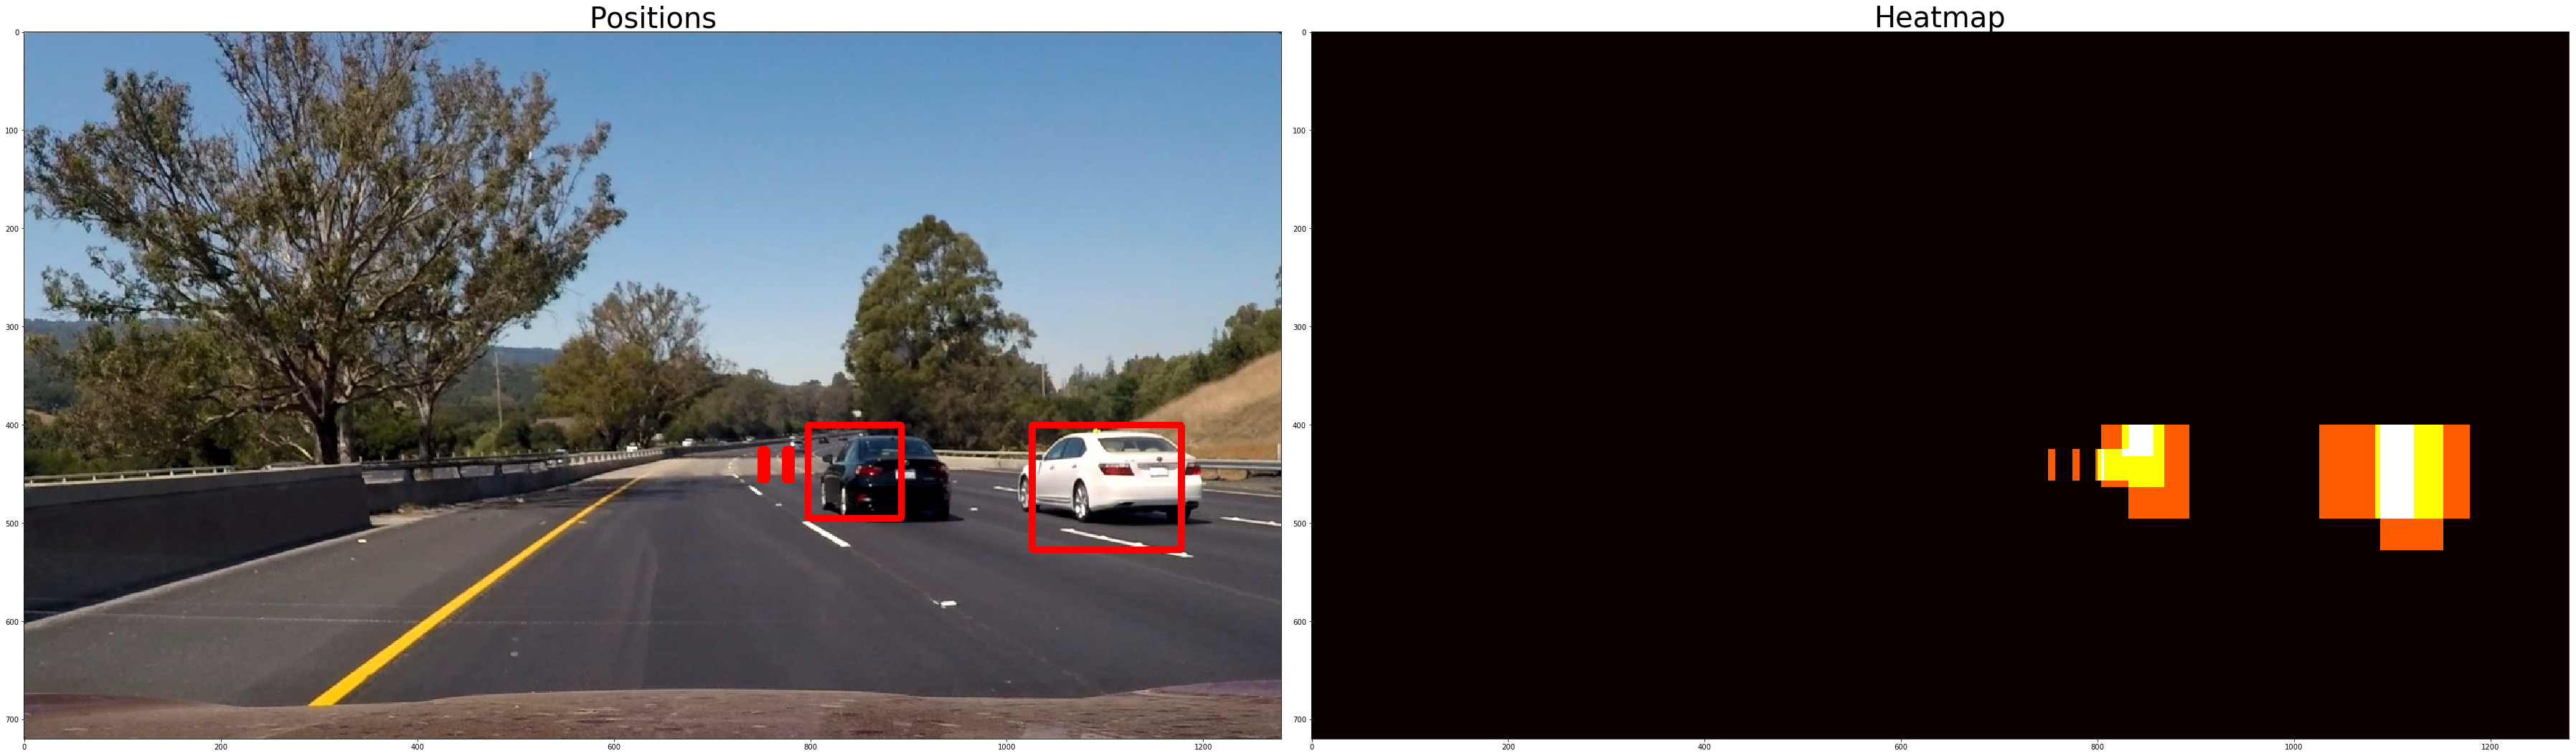

In [56]:
# read image
image = cv2.imread('./test_images/test6.jpg')

frame = vehicle_detector.detect(image, rgb = False, across_frames = False, show_region = False, verbose = True)


In [ ]:
def getVehicleDetector():
    '''
    Create an instance of vehicle detector to detect vehicles in image frame
    '''
    
    # load classifier from disk
    classifier = pickle.load(open('model.p', 'rb'))
    heatmap    = ImageHeatmap()
    
    # initialize vehicle detector
    vehicle_detector = VehicleDetector(classifier, heatmap)
    
    return vehicle_detector

### Video Frames

In [ ]:
# Project Vidoe
project_video_name   = 'project_video.mp4'
project_video_output = 'test_videos_output/project_video.mp4'

vehicle_detector = getVehicleDetector()

video_clip = VideoFileClip(project_video_name)

output_clip = video_clip.fl_image(vehicle_detector.detect)

%time output_clip.write_videofile(project_video_output, audio=False)
